# Data Curation Notebook A - Processing of GWAS and RV Data

- Filter CV and RV studies
- Filter gene associations
- Convert to NCBI Gene IDs
- Clean the trait EFO codes

Figures generated in this notebook:
- None

Datasets generated in this notebook:
- Supplemental Table 1 - Common and Rare Variant study information and associations

Files created:
- os.path.join(datadir, 'GWASCatalog', 'gwas_catalog_Jan29_2025.txt.final')
- os.path.join(datadir,'GWASCatalog', 'cleaned_gwas-catalog-v1.0.3.1-studies-r2025-03-26.tsv')
- os.path.join(datadir,'RAVAR' ,'gene_fulltable_06112024.txt.entrez')
- os.path.join(datadir,'RAVAR', 'rv_study_info_cleaned_with_manual_mapped_Mar28.tsv')
- '/cellar/users/snwright/Data/Transfer/RVC/data/RV Study Info - Shared Traits6.tsv'

## Set Up

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from collections import defaultdict
from tqdm import tqdm
import networkx as nx
from matplotlib_venn import venn2, venn3
from neteval import gene_mapper as gm
from neteval import query_ensembl as qe
from neteval import query_hgnc as qh
import obonet as obo

In [4]:
datadir='/cellar/users/snwright/Data/RareCommon/'
outdir='/cellar/users/snwright/Data/Transfer/RVC/'
figdir='/cellar/users/snwright/Data/Transfer/RVC/figures/RAVAR_GWASCat/'

In [5]:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams.update({'font.size': 7})
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['hatch.linewidth'] = 0.5
plt.rcParams['xtick.major.width'] = 0.4
plt.rcParams['ytick.major.width'] = 0.4
plt.rcParams['xtick.minor.width'] = 0.3
plt.rcParams['ytick.minor.width'] = 0.3
plt.rcParams['legend.frameon'] = False
plt.rcParams['xtick.major.size'] = 3
plt.rcParams['ytick.major.size'] = 3
plt.rcParams['xtick.minor.size'] = 2
plt.rcParams['ytick.minor.size'] = 2
plt.rcParams['xtick.major.pad'] = 1
plt.rcParams['ytick.major.pad'] = 1
plt.rcParams['axes.labelpad'] = 1
plt.rcParams['patch.linewidth'] = 0.25

## RAVAR

In [36]:
ravar_genes = pd.read_csv(os.path.join(datadir,'RAVAR' ,'gene_fulltable_06112024.txt'),sep='\t', 
                            usecols=['Gene Symbol', 'Ensembl ID', 'Gene Type', 'CHR', 'Location', 'Reported Trait', 'Trait Label', 'Trait Ontology id', 'EFO synonym', 'P-value', 'PMID'])
#replace '−' with '-'
ravar_genes['P-value'] = ravar_genes['P-value'].apply(lambda x: float(x.replace('−','-')) if type(x) == str else float(x))
ravar_genes['TRAIT_CODE'] = ravar_genes['Trait Ontology id'].apply(lambda x: x.replace(":", "_") if type(x) == str else x)
ravar_genes['logp'] = -1 * np.log10(ravar_genes['P-value'] + 1e-250)

/tmp/ipykernel_687938/288862769.py:1: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  ravar_genes = pd.read_csv(os.path.join(datadir,'RAVAR' ,'gene_fulltable_06112024.txt'),sep='\t',


In [37]:
print('Reported traits', len(ravar_genes['Reported Trait'].unique()))
print('Total traits with Ontology', len(ravar_genes['Trait Ontology id'].unique()))
print('Total genes', len(ravar_genes['Gene Symbol'].unique()))
print('Unique studies', len(ravar_genes['PMID'].unique()))
print('Min p-value', ravar_genes['P-value'].min())
print('Max p-value', ravar_genes['P-value'].max())

Reported traits 3049
Total traits with Ontology 1468
Total genes 12850
Unique studies 200
Min p-value 0.0
Max p-value 9.94e-05


(0.5, 100000)

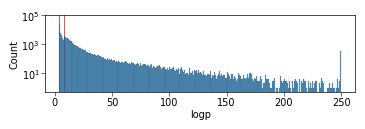

In [39]:
_  = plt.figure(figsize=(4, 1))
sns.histplot(ravar_genes.logp, bins=300)
plt.yscale('log')
plt.vlines(x=4,ymin=0.5, ymax=1000000, color='red', zorder= 0, linewidth=0.5)
plt.vlines(x=8,ymin=0.5, ymax=1000000, color='red', zorder= 0, linewidth=0.5)
plt.ylim(0.5, 100000)

### Filter studies

### TODO map to NCBI gene ids

### Clean EFO trait mappings

## GWAS Catalog

Filter the gwas catalog data
### Filter GWAS studies

In [6]:
def clean_gwas_catalog_data(datafile, outfile, pval_th=5e-8, include_intergenic=False):
    """Clean the GWAS Catalog data and write to a new file.

    Args:
        datafile (str): file path for GWAS Catalog data
        outfile (str): output file for cleaned data
        pval_th (float): p-value threshold for filtering
        include_intergenic (bool): whether to include intergenic associations

    Returns:
        None
    """
    cols= ['DATE', 'PUBMEDID', 'DISEASE/TRAIT', 'MAPPED_GENE', 'SNP_GENE_IDS', 'P-VALUE', 'OR or BETA' ,'MAPPED_TRAIT', 
           'MAPPED_TRAIT_URI', 'INTERGENIC', 'STUDY ACCESSION', 'SNP_ID_CURRENT', 'INITIAL SAMPLE SIZE', 'GENOTYPING TECHNOLOGY']    
    if include_intergenic:
        cols = cols + ['UPSTREAM_GENE_ID', 'DOWNSTREAM_GENE_ID', 'UPSTREAM_GENE_DISTANCE', 'DOWNSTREAM_GENE_DISTANCE']
    data = pd.read_csv(datafile, sep="\t", usecols=cols)
    # filter on pval
    data = data[data["P-VALUE"] <= pval_th]
    # filter on gene and trait present
    data = data.dropna(subset=['SNP_GENE_IDS', "MAPPED_TRAIT_URI"])
    # filter out intergenic
    if not include_intergenic:
        data = data[data["INTERGENIC"] == 0]
    # remove associations with multiple genes
    data = data[~data["SNP_GENE_IDS"].str.contains(",")]
    # remove associations with multiple traits
    data = data[~data["MAPPED_TRAIT_URI"].str.contains(",")]
    # create trait code
    data['TRAIT_CODE'] = data['MAPPED_TRAIT_URI'].apply(lambda x: x.split('/')[-1])
    # write the cleaned file
    data.to_csv(outfile, sep="\t", index=False)

In [7]:
clean_gwas_catalog_data(os.path.join(datadir, 'GWASCatalog', 'gwas_catalog_Jan29_2025.txt'), os.path.join(datadir, 'GWASCatalog', 'gwas_catalog_Jan29_2025.txt.cleaned_test'), pval_th=1)

/tmp/ipykernel_1982271/2161290776.py:17: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(datafile, sep="\t", usecols=cols)


KeyboardInterrupt: 

### Convert to NCBI Gene IDs

In [ ]:
gwas_genes= pd.read_csv(os.path.join(datadir, 'GWASCatalog', 'gwas_catalog_Jan29_2025.txt.cleaned_test'), sep="\t")

In [ ]:
if False:
    ensembl_map, missing = qe.get_latest_ensembl_id(gwas_genes['SNP_GENE_IDS'].unique())
    ensembl_to_entrez, missing_entrez = gm.convert_node_ids(ensembl_map['to'].values, 'Ensembl', 'Entrez')
    ensembl_map['Entrez'] = [ensembl_to_entrez[x] if x in ensembl_to_entrez else '' for x in ensembl_map['to']]
    id_ensembl = gwas_genes.merge(ensembl_map.loc[:, ('from', 'Entrez')], left_on='SNP_GENE_IDS', right_on='from', how='left')
    symbol_map, symbol_missing = qh.perform_hgnc_query(id_ensembl[(id_ensembl['Entrez'].isnull()) | (id_ensembl['Entrez']== '')]['MAPPED_GENE'].unique(), 'Symbol', 'Symbol')
    symbol_to_entrez, missing = gm.convert_node_ids(list(symbol_map.values()), 'Symbol', 'Entrez')
    symbol_map = pd.DataFrame(symbol_map.items(), columns=['from', 'to'])
    symbol_map['Entrez'] = [symbol_to_entrez[x] if x in symbol_to_entrez else '' for x in symbol_map['to']]
    id_symbol = gwas_genes.iloc[~id_ensembl.index].merge(symbol_map.loc[:, ('from', 'Entrez')], left_on='MAPPED_GENE', right_on='from', how='inner')
    id_ensembl = id_ensembl[(id_ensembl['Entrez'] != '') & (~id_ensembl['Entrez'].isnull())]
    converted_gwas_genes = pd.concat([id_ensembl, id_symbol])
    converted_gwas_genes = converted_gwas_genes[converted_gwas_genes['Entrez'] != '']
    converted_gwas_genes.to_csv(os.path.join(datadir, 'GWASCatalog', 'gwas_catalog_Jan29_2025.txt.cleaned_test.entrez'), sep="\t", index=False)
else:
    converted_gwas_genes = pd.read_csv(os.path.join(datadir, 'GWASCatalog', 'gwas_catalog_Jan29_2025.txt.cleaned_test.entrez'), sep="\t")

In [41]:
gwas_genes= pd.read_csv(os.path.join(datadir, 'GWASCatalog', 'gwas_catalog_Jan29_2025.txt.cleanedJan29'), sep="\t")
gwas_genes_old = pd.read_csv(os.path.join(datadir, 'GWASCatalog/Jan22', 'gwas_cat_download_Jan22.txt.cleanedJun17'), sep="\t")

### Clean EFO trait mappings

# ---- OLD ---

### Load EFO Ontology

In [34]:
efo = obo.read_obo('http://www.ebi.ac.uk/efo/efo.obo')
efo_root='EFO:0000001'

In [35]:
n = list(efo.nodes())

In [6]:
depths = nx.single_target_shortest_path_length(efo, efo_root)
depth_dict = {source:distance for source, distance in depths}

In [1]:
def return_more_specific_code(codeA, codeB, depth_dict, study_data):
    if codeA == codeB:
        return codeA
    try:
        codeA, codeB = [code.replace('_', ':') for code in [codeA, codeB]]
    except:
        if type(codeA) == float:
            return codeB
        elif type(codeB) == float:
            return codeA
        else:
            print('TYPE_ERROR:', codeA, codeB)
    present = [code in depth_dict for code in [codeA, codeB]]
    if sum(present) == 2:

        depthA = depth_dict[codeA]
        depthB = depth_dict[codeB]
        if depthA > depthB:
            return codeA
        elif depthB > depthA:
            return codeB
        # if they have the same depth, return the one with fewer studies listed. 
        else:
            return check_study_counts(codeA, codeB, study_data)
    elif sum(present) == 1:
        return [codeA, codeB][present.index(True)]
    else:
        print(f'Neither {codeA} or {codeB} present in EFO. Returning {codeB}')
        return codeB
    
def check_study_counts(codeA, codeB, data):
    codeA, codeB = [code.replace(':', '_') for code in [codeA, codeB]]
    codeA_count = data[data.STUDY_EFO==codeA].shape[0] + data[data.TRAIT_EFO==codeA].shape[0]
    codeB_count = data[data.STUDY_EFO==codeB].shape[0] + data[data.TRAIT_EFO==codeB].shape[0]
    if codeA_count < codeB_count:
        return codeA
    if codeB_count < codeA_count:
        return codeB
    elif codeB_count == codeA_count:
        print(f'{codeA} and {codeB} have equal study counts. Returning {codeB}')
        return manually_determine_correct_code(codeA, codeB, data)

def manually_determine_correct_code(codeA, codeB, data):
    sub_data = data[(data.STUDY_EFO==codeA) & (data.TRAIT_EFO==codeB)]
    for col in ['DISEASE/TRAIT', 'MAPPED_TRAIT', 'STUDY_EFO', 'Disease trait', 'EFO term', 'TRAIT_EFO']:
        print(f'{col}:', sub_data[col].values)
    return input()
    

## Load raw data

In [42]:
gwas_genes[gwas_genes['STUDY ACCESSION']=='GCST001220']

,PUBMEDID,DATE,DISEASE/TRAIT,MAPPED_GENE,SNP_GENE_IDS,INTERGENIC,P-VALUE,OR or BETA,MAPPED_TRAIT,MAPPED_TRAIT_URI,STUDY ACCESSION,TRAIT_CODE
31074,21931564,2011-09-08,Metabolite levels,PYROXD2,ENSG00000119943,0.0,8.000000e-15,1.19,metabolite measurement,http://www.ebi.ac.uk/efo/EFO_0004725,GCST001220,EFO_0004725
31075,21931564,2011-09-08,Metabolite levels,AGXT2,ENSG00000113492,0.0,1.000000e-06,1.25,metabolite measurement,http://www.ebi.ac.uk/efo/EFO_0004725,GCST001220,EFO_0004725
31076,21931564,2011-09-08,Metabolite levels,ALMS1,ENSG00000116127,0.0,1.000000e-11,1.10,metabolite measurement,http://www.ebi.ac.uk/efo/EFO_0004725,GCST001220,EFO_0004725


In [43]:
print('Total reported traits', len(gwas_genes_old['DISEASE/TRAIT'].unique()))
print('Total traits with ontology', len(gwas_genes_old['TRAIT_CODE'].unique()))
print('Total genes', len(gwas_genes_old['MAPPED_GENE'].unique()))
print('Min p-value', gwas_genes_old['P-VALUE'].min())
print('Max p-value', gwas_genes_old['P-VALUE'].max())

Total reported traits 18955
Total traits with ontology 6863
Total genes 16052
Min p-value 0.0
Max p-value 1e-05


In [44]:
print('Total reported traits', len(gwas_genes['DISEASE/TRAIT'].unique()))
print('Total traits with ontology', len(gwas_genes['TRAIT_CODE'].unique()))
print('Total genes', len(gwas_genes['MAPPED_GENE'].unique()))
print('Min p-value', gwas_genes['P-VALUE'].min())
print('Max p-value', gwas_genes['P-VALUE'].max())

Total reported traits 24893
Total traits with ontology 7351
Total genes 17133
Min p-value 0.0
Max p-value 1e-05


Score distributions

In [45]:
gwas_genes['logp'] = -1 * np.log10(gwas_genes['P-VALUE']+1e-300)

In [46]:
gwas_genes['logp'].describe()

count    336840.000000
mean         22.148681
std          40.167155
min           5.000000
25%           8.000000
50%          10.698970
75%          18.000000
max         300.000000
Name: logp, dtype: float64

(0.5, 100000)

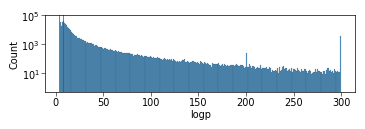

In [47]:
_  = plt.figure(figsize=(4, 1))
sns.histplot(gwas_genes.logp, bins=300)
plt.yscale('log')
plt.vlines(x=4,ymin=0.5, ymax=1000000, color='red', zorder= 0, linewidth=0.5)
plt.vlines(x=8,ymin=0.5, ymax=1000000, color='red', zorder= 0, linewidth=0.5)
plt.ylim(0.5, 100000)

In [56]:
gwas_genes.head()

,PUBMEDID,DATE,DISEASE/TRAIT,MAPPED_GENE,SNP_GENE_IDS,INTERGENIC,P-VALUE,MAPPED_TRAIT,MAPPED_TRAIT_URI,TRAIT_CODE,logp
0,23583979,2013-04-14,Heart rate,SYT10,ENSG00000110975,0.0,6.000000e-24,heart rate,http://www.ebi.ac.uk/efo/EFO_0004326,EFO_0004326,23.221849
1,23583979,2013-04-14,Heart rate,MYH6,ENSG00000197616,0.0,5.000000e-45,heart rate,http://www.ebi.ac.uk/efo/EFO_0004326,EFO_0004326,44.301030
2,23583979,2013-04-14,Heart rate,KIAA1755,ENSG00000149633,0.0,5.000000e-29,heart rate,http://www.ebi.ac.uk/efo/EFO_0004326,EFO_0004326,28.301030
3,23583979,2013-04-14,Heart rate,CCDC141,ENSG00000163492,0.0,4.000000e-26,heart rate,http://www.ebi.ac.uk/efo/EFO_0004326,EFO_0004326,25.397940
4,23583979,2013-04-14,Heart rate,CHRM2,ENSG00000181072,0.0,1.000000e-12,heart rate,http://www.ebi.ac.uk/efo/EFO_0004326,EFO_0004326,12.000000


### GWAS Catalog Study info

In [6]:
def return_more_specific_code(codeA, codeB, depth_dict, study_data):
    # are the codes the same?
    if codeA == codeB:
        return codeA
    # is it just a formatting issue?
    try:
        codeA, codeB = [code.replace('_', ':') for code in [codeA, codeB]]
    except:
        # is one not an EFO code?
        if type(codeA) == float:
            return codeB
        elif type(codeB) == float:
            return codeA
        else:
            print('TYPE_ERROR:', codeA, codeB)
    
    present = [code in depth_dict for code in [codeA, codeB]]
    if sum(present) == 2:
        depthA = depth_dict[codeA]
        depthB = depth_dict[codeB]
        if depthA > depthB:
            return codeA
        elif depthB > depthA:
            return codeB
        else:
            return check_study_counts(codeA, codeB, study_data)
    # return the code that is present
    elif sum(present) == 1:
        return [codeA, codeB][present.index(True)]
    # manually determine the better code
    else:
        print(f'Neither {codeA} or {codeB} present in EFO. Returning {codeB}')
        return codeB
    
def check_study_counts(codeA, codeB, data):
    codeA, codeB = [code.replace(':', '_') for code in [codeA, codeB]]
    codeA_count = data[data.STUDY_EFO==codeA].shape[0] + data[data.TRAIT_EFO==codeA].shape[0]
    codeB_count = data[data.STUDY_EFO==codeB].shape[0] + data[data.TRAIT_EFO==codeB].shape[0]
    if codeA_count < codeB_count:
        return codeA
    if codeB_count < codeA_count:
        return codeB
    elif codeB_count == codeA_count:
        print(f'{codeA} and {codeB} have equal study counts. Returning {codeB}')
        return manually_determine_correct_code(codeA, codeB, data)

def manually_determine_correct_code(codeA, codeB, data):
    sub_data = data[(data.STUDY_EFO==codeA) & (data.TRAIT_EFO==codeB)]
    for col in ['DISEASE/TRAIT', 'MAPPED_TRAIT', 'STUDY_EFO', 'Disease trait', 'EFO term', 'TRAIT_EFO']:
        print(f'{col}:', sub_data[col].values)
    return input()
    

In [7]:
if False:
    gwas_study = pd.read_csv(os.path.join(datadir, 'GWASCatalog', 'study_info.v1.0.3.1_Jan29_2025.txt'), sep="\t", 
                            usecols=['DISEASE/TRAIT','ASSOCIATION COUNT','MAPPED_TRAIT', 'MAPPED_TRAIT_URI','STUDY ACCESSION',
                            'BACKGROUND TRAIT', 'MAPPED BACKGROUND TRAIT', 'MAPPED BACKGROUND TRAIT URI','COHORT', 
                            'FULL SUMMARY STATISTICS', 'SUMMARY STATS LOCATION', 'DATE ADDED TO CATALOG', 'INITIAL SAMPLE SIZE',
                            'GENOTYPING TECHNOLOGY'  ])
    trait_mappings = pd.read_csv(os.path.join(datadir, 'GWASCatalog', 'trait_mappings.txt'), sep="\t", usecols=['Disease trait', 'EFO term', 'EFO URI'])
    trait_mappings['TRAIT_EFO'] = trait_mappings['EFO URI'].apply(lambda x: x.split('/')[-1])
    trait_mappings.drop(columns=['EFO URI'], inplace=True)
    #gwas_study = gwas_study.loc[(gwas_study['MAPPED BACKGROUND TRAIT URI'].isna()) & (gwas_study['FULL SUMMARY STATISTICS'] == 'yes')]
    gwas_study = gwas_study.loc[~gwas_study['MAPPED_TRAIT_URI'].isna()]
    gwas_study = gwas_study.loc[~gwas_study["MAPPED_TRAIT_URI"].str.contains(",")]
    gwas_study['STUDY_EFO'] = gwas_study['MAPPED_TRAIT_URI'].apply(lambda x: x.split('/')[-1])
    gwas_study['GENOTYPING TECHNOLOGY'] = gwas_study['GENOTYPING TECHNOLOGY'].apply(lambda x: x.split('[')[0].strip())
    # problem is here where there can be more than one match in the trait mappings. What
    # was the problem I was trying to solve? 
    gwas_study = gwas_study.merge(trait_mappings, left_on='DISEASE/TRAIT', right_on='Disease trait', how='left')
    gwas_study['TRAIT_CODE'] = gwas_study.apply(lambda x: return_more_specific_code(x['STUDY_EFO'], x['TRAIT_EFO'], depth_dict, gwas_study), axis=1)
    gwas_study.loc[:, ('DISEASE/TRAIT', 'ASSOCIATION COUNT', 'STUDY ACCESSION','COHORT','MAPPED BACKGROUND TRAIT URI', 
                       'SUMMARY STATS LOCATION','TRAIT_CODE', 'DATE ADDED TO CATALOG', 'INITIAL SAMPLE SIZE', 'GENOTYPING TECHNOLOGY')].to_csv(os.path.join(datadir, 'GWASCatalog','trait_info_cleaned_Jan29_2025.txt'), sep='\t', index=False)
else:
    gwas_study = pd.read_csv(os.path.join(datadir, 'GWASCatalog','trait_info_cleaned_Jan29_2025.txt'), sep='\t')

In [49]:
gwas_genes[gwas_genes['STUDY ACCESSION'] == 'GCST001220']

,PUBMEDID,DATE,DISEASE/TRAIT,MAPPED_GENE,SNP_GENE_IDS,INTERGENIC,P-VALUE,OR or BETA,MAPPED_TRAIT,MAPPED_TRAIT_URI,STUDY ACCESSION,TRAIT_CODE,logp
31074,21931564,2011-09-08,Metabolite levels,PYROXD2,ENSG00000119943,0.0,8.000000e-15,1.19,metabolite measurement,http://www.ebi.ac.uk/efo/EFO_0004725,GCST001220,EFO_0004725,14.09691
31075,21931564,2011-09-08,Metabolite levels,AGXT2,ENSG00000113492,0.0,1.000000e-06,1.25,metabolite measurement,http://www.ebi.ac.uk/efo/EFO_0004725,GCST001220,EFO_0004725,6.00000
31076,21931564,2011-09-08,Metabolite levels,ALMS1,ENSG00000116127,0.0,1.000000e-11,1.10,metabolite measurement,http://www.ebi.ac.uk/efo/EFO_0004725,GCST001220,EFO_0004725,11.00000


In [50]:
trait_mappings['Disease trait'].value_counts().sort_values(ascending=False)

Disease trait
Metabolite levels                                   233
Obesity-related traits                               66
Blood protein levels                                 56
Blood protein levels in cardiovascular risk          55
Cardiometabolic traits                               53
                                                   ... 
Cutaneous squamous cell carcinoma                     1
Zinc finger protein 10 levels                         1
Zinc finger protein 10 levels (ZNF10.11567.23.3)      1
Small intestine neuroendocrine tumor                  1
Cognitive test performance                            1
Name: count, Length: 53933, dtype: int64

In [28]:
gwas_genes[gwas_genes['MAPPED_TRAIT_URI']=='http://www.ebi.ac.uk/efo/EFO_0007813']

,PUBMEDID,DATE,DISEASE/TRAIT,MAPPED_GENE,SNP_GENE_IDS,INTERGENIC,P-VALUE,OR or BETA,MAPPED_TRAIT,MAPPED_TRAIT_URI,STUDY ACCESSION,TRAIT_CODE
32129,23823483,2013-07-02,Metabolite levels,CNTNAP2,ENSG00000174469,0.0,1.000000e-06,0.182363,cotinine measurement,http://www.ebi.ac.uk/efo/EFO_0007813,GCST009391,EFO_0007813
32130,23823483,2013-07-02,Metabolite levels,CDH4,ENSG00000179242,0.0,1.000000e-06,0.697002,cotinine measurement,http://www.ebi.ac.uk/efo/EFO_0007813,GCST009391,EFO_0007813
32131,23823483,2013-07-02,Metabolite levels,CTNNA2,ENSG00000066032,0.0,4.000000e-06,0.207161,cotinine measurement,http://www.ebi.ac.uk/efo/EFO_0007813,GCST009391,EFO_0007813
113339,29631575,2018-04-10,Cotinine levels in smokers with chronic obstru...,HYKK,ENSG00000188266,0.0,3.000000e-07,0.120000,cotinine measurement,http://www.ebi.ac.uk/efo/EFO_0007813,GCST005916,EFO_0007813


In [51]:
trait_mappings = pd.read_csv(os.path.join(datadir, 'GWASCatalog', 'trait_mappings.txt'), sep="\t", usecols=['Disease trait', 'EFO term', 'EFO URI'])
trait_mappings[trait_mappings['Disease trait']=='Metabolite levels']

,Disease trait,EFO term,EFO URI
765,Metabolite levels,cotinine measurement,http://www.ebi.ac.uk/efo/EFO_0007813
1656,Metabolite levels,symmetrical dimethylarginine measurement,http://www.ebi.ac.uk/efo/EFO_0006523
1664,Metabolite levels,L-arginine measurement,http://www.ebi.ac.uk/efo/EFO_0006524
5262,Metabolite levels,plasma betaine measurement,http://www.ebi.ac.uk/efo/EFO_0007787
5355,Metabolite levels,thyroxine measurement,http://www.ebi.ac.uk/efo/EFO_0005130
...,...,...,...
47923,Metabolite levels,valine measurement,http://www.ebi.ac.uk/efo/EFO_0009792
49240,Metabolite levels,serotonin measurement,http://www.ebi.ac.uk/efo/EFO_0004846
52720,Metabolite levels,triiodothyronine measurement,http://www.ebi.ac.uk/efo/EFO_0008392
56815,Metabolite levels,kynurenine measurement,http://www.ebi.ac.uk/efo/EFO_0008529


In [19]:
gwas_study[gwas_study['STUDY ACCESSION'] =='GCST001220']

,DISEASE/TRAIT,ASSOCIATION COUNT,STUDY ACCESSION,COHORT,MAPPED BACKGROUND TRAIT URI,SUMMARY STATS LOCATION,TRAIT_CODE,DATE ADDED TO CATALOG,INITIAL SAMPLE SIZE
4895,Metabolite levels,3,GCST001220,NaN,NaN,NaN,EFO_0007813,2012-02-10,142 European ancestry female twins
4896,Metabolite levels,3,GCST001220,NaN,NaN,NaN,EFO:0006523,2012-02-10,142 European ancestry female twins
4897,Metabolite levels,3,GCST001220,NaN,NaN,NaN,EFO:0006524,2012-02-10,142 European ancestry female twins
4898,Metabolite levels,3,GCST001220,NaN,NaN,NaN,EFO:0007787,2012-02-10,142 European ancestry female twins
4899,Metabolite levels,3,GCST001220,NaN,NaN,NaN,EFO:0005130,2012-02-10,142 European ancestry female twins
...,...,...,...,...,...,...,...,...,...
5123,Metabolite levels,3,GCST001220,NaN,NaN,NaN,EFO:0009792,2012-02-10,142 European ancestry female twins
5124,Metabolite levels,3,GCST001220,NaN,NaN,NaN,EFO:0004846,2012-02-10,142 European ancestry female twins
5125,Metabolite levels,3,GCST001220,NaN,NaN,NaN,EFO_0008392,2012-02-10,142 European ancestry female twins
5126,Metabolite levels,3,GCST001220,NaN,NaN,NaN,EFO:0008529,2012-02-10,142 European ancestry female twins


Restrict to those with at least one association

In [52]:
gwas_study = gwas_study.loc[gwas_study['ASSOCIATION COUNT'] >= 1]
gwas_study.shape

(57469, 9)

In [53]:
gwas_study.TRAIT_CODE.nunique()

11315

Identify common traits not in the overlap set

In [59]:
with open(os.path.join('/cellar/users/snwright/Data/RareCommon/inputs/overlap_traits_Jun27.txt'), 'r') as f:
    overlap_traits = [x.strip() for x in f.readlines()]

In [61]:
len(overlap_traits)

552

In [90]:
# keep those not in overlap
testing_studies = [t for t in gwas_study[~gwas_study['SUMMARY STATS LOCATION'].isna()].TRAIT_CODE.unique() if (t not in overlap_traits) and (t.replace('_', ':') not in overlap_traits)]

In [91]:
# keep those with summary statistics
testing_study = gwas_study[gwas_study.TRAIT_CODE.isin(testing_studies) & ~gwas_study['SUMMARY STATS LOCATION'].isna()]

In [92]:
# keep those with no background trait
testing_study = testing_study[testing_study['MAPPED BACKGROUND TRAIT URI'].isna()]

In [93]:
# keep those with at least one association
testing_study = testing_study[testing_study['ASSOCIATION COUNT'] > 0]

In [94]:
# look at the distribution of associations
testing_study['ASSOCIATION COUNT'].describe(percentiles=[0.75,0.8,0.85, 0.9, 0.95, 0.99])

count    18853.000000
mean        12.481197
std         57.574850
min          1.000000
50%          2.000000
75%          4.000000
80%          6.000000
85%          9.000000
90%         15.000000
95%         47.000000
99%        200.000000
max       2008.000000
Name: ASSOCIATION COUNT, dtype: float64

In [95]:
testing_study = testing_study[testing_study['ASSOCIATION COUNT'] >= 5]

In [118]:
# map traits to EFO categories?
global_map = assign_trait_list_to_global(list(testing_study.TRAIT_CODE.unique()), efo)
# map disease categories
disease_map = assign_trait_list_to_global(global_map['EFO:0000408'],efo , [node for node in efo.predecessors( 'EFO:0000408')] )
# map measurement categories
measure_map = assign_trait_list_to_global(global_map['EFO:0001444'],efo, [node for node in efo.predecessors( 'EFO:0001444')] )
# map abnormality categories
abnorm_map = assign_trait_list_to_global(global_map['HP:0000118'],efo, [node for node in efo.predecessors( 'HP:0000118')] )

EFO:0003761 not in efo graph


In [139]:
import random as rn
def select_random_traits(trait_map):
    traits = []
    for k in trait_map.keys():
        n = len(trait_map[k])
        if n == 0:
            pass
        elif n == 1:
            traits += trait_map[k]
        else:
            n_select = min(1, int(n*0.1))
            traits += rn.sample(trait_map[k], n_select)
    return set(traits)
disease_traits = select_random_traits(disease_map)
measurement_traits = select_random_traits(measure_map)
abnorm_traits = select_random_traits(abnorm_map)
all_test_traits = disease_traits.union(measurement_traits).union(abnorm_traits)

In [141]:
all_test_traits =[x.replace(':', '_') for x in list(all_test_traits)]

In [142]:
testing_study['Trait'] = testing_study.TRAIT_CODE.apply(lambda x: x.replace(':', '_'))

In [152]:
exclude = list(testing_df.Trait.value_counts()[(testing_df.Trait.value_counts() >= 10)].index)

In [154]:
with open(os.path.join('/cellar/users/snwright/Data/RareCommon/inputs/testing/testing_gwas_traits_Dec3.txt'), 'w') as f:
    for trait in all_test_traits:
        if trait not in exclude:
            f.write(trait + '\n')

In [166]:
testing_df = testing_study[testing_study.Trait.isin(all_test_traits) & ~testing_study.Trait.isin(exclude)].drop_duplicates()

In [167]:
testing_df

,DISEASE/TRAIT,ASSOCIATION COUNT,STUDY ACCESSION,COHORT,MAPPED BACKGROUND TRAIT URI,SUMMARY STATS LOCATION,TRAIT_CODE,Trait
312,Ischemic stroke (cardioembolic),10,GCST005842,NaN,NaN,http://ftp.ebi.ac.uk/pub/databases/gwas/summar...,EFO:1001976,EFO_1001976
313,Ischemic stroke (cardioembolic),10,GCST005842,NaN,NaN,http://ftp.ebi.ac.uk/pub/databases/gwas/summar...,EFO_1001976,EFO_1001976
318,Ischemic stroke (cardioembolic),5,GCST006910,NaN,NaN,http://ftp.ebi.ac.uk/pub/databases/gwas/summar...,EFO:1001976,EFO_1001976
319,Ischemic stroke (cardioembolic),5,GCST006910,NaN,NaN,http://ftp.ebi.ac.uk/pub/databases/gwas/summar...,EFO_1001976,EFO_1001976
443,Smoking behaviour (cigarettes smoked per day),8,GCST007602,NaN,NaN,http://ftp.ebi.ac.uk/pub/databases/gwas/summar...,EFO_0006525,EFO_0006525
...,...,...,...,...,...,...,...,...
114812,Mitochondrial DNA heteroplasmy (chrM:302:A:AC ...,20,GCST90268467,UKB,NaN,http://ftp.ebi.ac.uk/pub/databases/gwas/summar...,EFO_0600008,EFO_0600008
114821,Mitochondrial DNA heteroplasmy (chrM:302:A:ACC...,8,GCST90268476,UKB,NaN,http://ftp.ebi.ac.uk/pub/databases/gwas/summar...,EFO_0600008,EFO_0600008
114827,Mitochondrial DNA heteroplasmy (chrM:16183:AC:...,6,GCST90268482,UKB,NaN,http://ftp.ebi.ac.uk/pub/databases/gwas/summar...,EFO_0600008,EFO_0600008
114828,Mitochondrial DNA heteroplasmy (chrM:16183:A:A...,5,GCST90268483,UKB,NaN,http://ftp.ebi.ac.uk/pub/databases/gwas/summar...,EFO_0600008,EFO_0600008


In [170]:
print(testing_df[testing_df.Trait=='EFO_1001976']['SUMMARY STATS LOCATION'].values)

['http://ftp.ebi.ac.uk/pub/databases/gwas/summary_statistics/GCST005001-GCST006000/GCST005842'
 'http://ftp.ebi.ac.uk/pub/databases/gwas/summary_statistics/GCST005001-GCST006000/GCST005842'
 'http://ftp.ebi.ac.uk/pub/databases/gwas/summary_statistics/GCST006001-GCST007000/GCST006910'
 'http://ftp.ebi.ac.uk/pub/databases/gwas/summary_statistics/GCST006001-GCST007000/GCST006910'
 'http://ftp.ebi.ac.uk/pub/databases/gwas/summary_statistics/GCST90104001-GCST90105000/GCST90104541'
 'http://ftp.ebi.ac.uk/pub/databases/gwas/summary_statistics/GCST90104001-GCST90105000/GCST90104536']


In [172]:
urls = list(testing_df['SUMMARY STATS LOCATION'].unique())

In [180]:
testing_df.to_csv('/cellar/users/snwright/Data/RareCommon/inputs/testing/testing_study_info_Dec3.txt', sep='\t')

In [175]:
with open(os.path.join('/cellar/users/snwright/Data/RareCommon/inputs/testing/testing_gwas_sumstats_urls.txt'), 'w') as f:
    for url in urls:
        f.write(url + '\n')

In [177]:
len(urls)

136

## Subset to genes in both before further filtering of trait codes. Need to remove those that are too broad

#### Convert identifiers

RAVAR

In [54]:
if False:
    ensembl_map, missing = qe.get_latest_ensembl_id(ravar_genes['Ensembl ID'].unique())
    ensembl_to_entrez, missing_entrez = gm.convert_node_ids(ensembl_map['to'].values, 'Ensembl', 'Entrez')
    ensembl_map['Entrez'] = [ensembl_to_entrez[x] if x in ensembl_to_entrez else '' for x in ensembl_map['to']]
    id_ensembl = ravar_genes.merge(ensembl_map.loc[:, ('from', 'Entrez')], left_on='Ensembl ID', right_on='from', how='inner')
    id_ensembl = id_ensembl[id_ensembl['Entrez'] != '']
    symbol_map, symbol_missing = qh.perform_hgnc_query(id_ensembl[(id_ensembl['Entrez'].isnull()) | (id_ensembl['Entrez']== '')]['Gene Symbol'].unique(), 'Symbol', 'Symbol')
    symbol_to_entrez, missing = gm.convert_node_ids(list(symbol_map.values()), 'Symbol', 'Entrez')
    symbol_map = pd.DataFrame(symbol_map.items(), columns=['from', 'to'])
    symbol_map['Entrez'] = [symbol_to_entrez[x] if x in symbol_to_entrez else '' for x in symbol_map['to']]
    id_symbol = ravar_genes.iloc[~id_ensembl.index].merge(symbol_map.loc[:, ('from', 'Entrez')], left_on='Gene Symbol', right_on='from', how='inner')
    converted_ravar_genes = pd.concat([id_ensembl, id_symbol])
    converted_ravar_genes.to_csv(os.path.join(datadir,'RAVAR' ,'gene_fulltable_06112024.txt.entrez'), sep='\t', index=False)
else:
    converted_ravar_genes = pd.read_csv(os.path.join(datadir,'RAVAR' ,'gene_fulltable_06112024.txt.entrez'), sep='\t')

In [55]:
ravar_genes.head()

,Gene Symbol,Ensembl ID,Gene Type,CHR,Location,Reported Trait,Trait Label,Trait Ontology id,EFO synonym,P-value,PMID,TRAIT_CODE,logp
0,A1BG,ENSG00000121410,protein_coding,19,chr19:58345178-58353492,Abnormal findings on diagnostic imaging of oth...,abnormal result of diagnostic imaging,EFO:0009827,NaN,5.910000e-05,34375979,EFO_0009827,4.228413
1,A1CF,ENSG00000148584,protein_coding,10,chr10:50799409-50885675,Biochemistry Total Protein measurement,total blood protein measurement,EFO:0004536,serum total protein;TBP,5.000000e-09,34226706,EFO_0004536,8.301030
2,A1CF,ENSG00000148584,protein_coding,10,chr10:50799409-50885675,Biochemistry Calcium measurement,calcium measurement,EFO:0004838,calcium levels,2.100000e-08,34226706,EFO_0004838,7.677781
3,A1CF,ENSG00000148584,protein_coding,10,chr10:50799409-50885675,Biochemistry SHBG measurement,sex hormone-binding globulin measurement,EFO:0004696,SHBG levels;SHBG level,1.000000e-06,34226706,EFO_0004696,6.000000
4,A1CF,ENSG00000148584,protein_coding,10,chr10:50799409-50885675,Biochemistry Gamma Glutamyl transferase measur...,serum gamma-glutamyl transferase measurement,EFO:0004532,GGT measurement;Gamma gluatamyl transferase le...,1.400000e-19,34226706,EFO_0004532,18.853872


In [56]:
# add the PMCIDs to the converted data
converted_ravar_genes = converted_ravar_genes.merge(ravar_genes.loc[:, ('PMID', 'Ensembl ID', 'Trait Label', 'P-value', 'Reported Trait', 'Location',
                        'Gene Symbol')].drop_duplicates(), on=['Gene Symbol', 'Ensembl ID', 'Trait Label', 'P-value', 'Reported Trait', 'Location'], how='left')

In [57]:
converted_ravar_genes.shape

(76468, 15)

GWAS Cat

In [5]:
if False:
    ensembl_map, missing = qe.get_latest_ensembl_id(gwas_genes['SNP_GENE_IDS'].unique())
    ensembl_to_entrez, missing_entrez = gm.convert_node_ids(ensembl_map['to'].values, 'Ensembl', 'Entrez')
    ensembl_map['Entrez'] = [ensembl_to_entrez[x] if x in ensembl_to_entrez else '' for x in ensembl_map['to']]
    id_ensembl = gwas_genes.merge(ensembl_map.loc[:, ('from', 'Entrez')], left_on='SNP_GENE_IDS', right_on='from', how='left')
    symbol_map, symbol_missing = qh.perform_hgnc_query(id_ensembl[(id_ensembl['Entrez'].isnull()) | (id_ensembl['Entrez']== '')]['MAPPED_GENE'].unique(), 'Symbol', 'Symbol')
    symbol_to_entrez, missing = gm.convert_node_ids(list(symbol_map.values()), 'Symbol', 'Entrez')
    symbol_map = pd.DataFrame(symbol_map.items(), columns=['from', 'to'])
    symbol_map['Entrez'] = [symbol_to_entrez[x] if x in symbol_to_entrez else '' for x in symbol_map['to']]
    id_symbol = gwas_genes.iloc[~id_ensembl.index].merge(symbol_map.loc[:, ('from', 'Entrez')], left_on='MAPPED_GENE', right_on='from', how='inner')
    id_ensembl = id_ensembl[(id_ensembl['Entrez'] != '') & (~id_ensembl['Entrez'].isnull())]
    converted_gwas_genes = pd.concat([id_ensembl, id_symbol])
    converted_gwas_genes = converted_gwas_genes[converted_gwas_genes['Entrez'] != '']
    converted_gwas_genes.to_csv(os.path.join(datadir, 'GWASCatalog', 'gwas_catalog_Jan29_2025.txt.cleanedJan29.entrez'), sep="\t", index=False)
else:
    converted_gwas_genes = pd.read_csv(os.path.join(datadir, 'GWASCatalog', 'gwas_catalog_Jan29_2025.txt.cleanedJan29.entrez'), sep="\t")

Genes in both data sets

In [6]:
print('Shared ensembl IDs:', len(set(ravar_genes['Ensembl ID']).intersection(set(gwas_genes['SNP_GENE_IDS']))))
print('Shared gene symbols:', len(set(ravar_genes['Gene Symbol']).intersection(set(gwas_genes['MAPPED_GENE']))))
print('Shared Entrez Gene IDs:', len(set(converted_ravar_genes['Entrez']).intersection(set(converted_gwas_genes['Entrez']))))

NameError: name 'ravar_genes' is not defined

Map updated EFO traits for GWASCat

In [60]:
converted_gwas_genes = converted_gwas_genes.drop(columns=['TRAIT_CODE', 'MAPPED_TRAIT_URI']).merge(gwas_study.drop(columns=['COHORT', 'ASSOCIATION COUNT', 'SUMMARY STATS LOCATION' ]), on=['STUDY ACCESSION', "DISEASE/TRAIT"])

In [61]:
gwas_genes = gwas_genes.drop(columns=['TRAIT_CODE']).merge(gwas_study.drop(columns=['COHORT', 'ASSOCIATION COUNT']), on=["STUDY ACCESSION","DISEASE/TRAIT"])